# Data Exploration

- interactive meaningful visualizations
- some descriptive metrics of the dataset

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read data

In [48]:
# local path to the data
PATH = "/Users/yiyily/Desktop/data/skylab_instagram_datathon_dataset.csv" 

X = pd.read_csv(PATH, sep=';')

## General properties

In [ ]:
# count unique values in every column
X.nunique()

We can remove calculation_type and period since they do not provide any information

In [50]:
# some basic dataset statistics
nrow = len(X.index)
nbrand = X.business_entity_doing_business_as_name.nunique()
start_date = X.period_end_date.min()
end_date = X.period_end_date.max()

# largest and smallest compset groups
ngroup = X.compset_group.nunique()
min_group = X.groupby('compset_group').business_entity_doing_business_as_name.nunique().sort_values().iloc[-1]
max_group = X.groupby('compset_group').business_entity_doing_business_as_name.nunique().sort_values().iloc[0]

print(f'The dataset contains {nrow} observations from {nbrand} brands that were recorded in the period from {start_date} to {end_date}.')
print(f'Brands are grouped into {ngroup} main competitive sets that vary in size from {max_group} brands to {min_group} brands')

The dataset contains 704313 observations from 706 brands that were recorded in the period from 2015-01-03 to 2023-09-16.
Brands are grouped into 20 main competitive sets that vary in size from 1 brands to 164 brands


In [40]:
import os

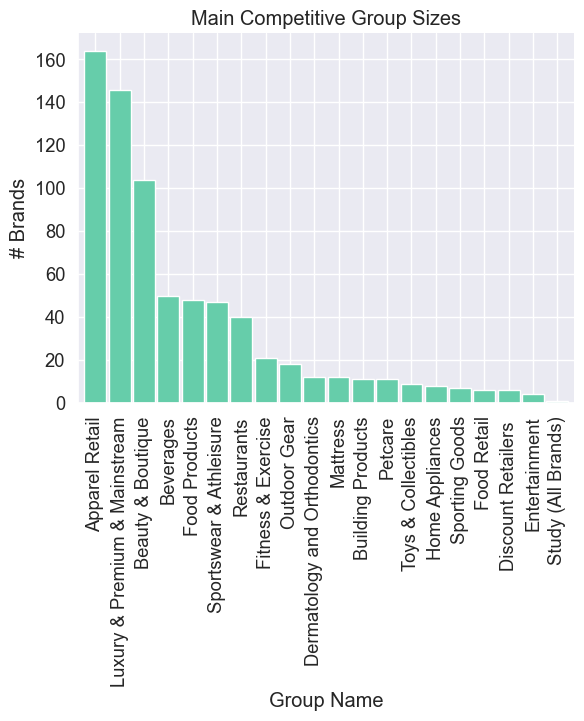

In [78]:
X.groupby('compset_group').business_entity_doing_business_as_name.nunique().sort_values(ascending=False).plot(kind='bar', width=0.9, color='mediumaquamarine')
plt.ylabel('# Brands')
plt.xlabel('Group Name')
plt.title('Main Competitive Group Sizes')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Change font
plt.rcParams['font.family'] = 'sans-serif'

# # Tilt x-tick labels
#plt.xticks(rotation=85)

#plt.savefig('../yiyi/figs/main_comp_size.png', dpi=300, bbox_inches='tight')
plt.show()

## Distribution of data over time

Are the dates equally distributed for every brand?
This is relevant for applying LSTM models.

In [6]:
print(f"Recording stops on the same date for all brands : {X.groupby('business_entity_doing_business_as_name').period_end_date.max().unique()[0]}")

Recording stops on the same date for all brands : 2023-09-16


Recording of different brands starts at different dates, but the majority starts on the same date


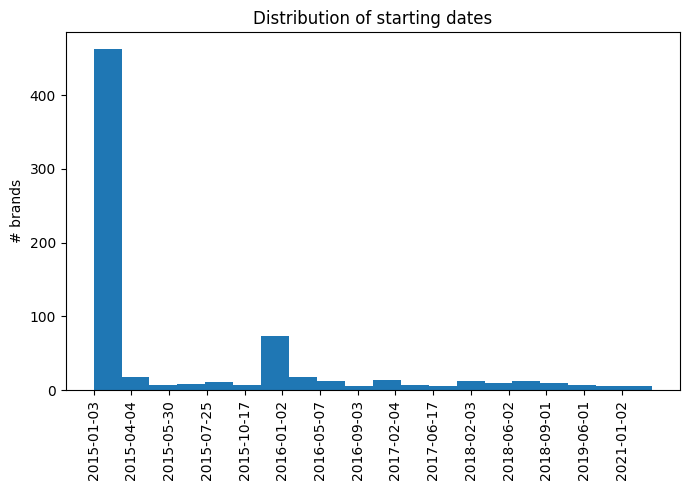

In [7]:
fig, ax = plt.subplots()

# plot distribution of recording start dates
X.groupby('business_entity_doing_business_as_name').period_end_date.min().sort_values().hist(xrot=90, ax=ax, bins = 20, grid=False)
tick_labs = ax.get_xticklabels()
ticks = ax.get_xticks()
ax.set_xticks(ticks[::5], tick_labs[::5])
ax.set_ylabel('# brands')
ax.set_title('Distribution of starting dates')

fig.set_figwidth(7)
fig.set_figheight(5)
fig.tight_layout()

print('Recording of different brands starts at different dates, but the majority starts on the same date')

In [8]:
print(f"{sum(X.groupby('business_entity_doing_business_as_name').period_end_date.min()>'2015-01-03')} brands start at a later date")

253 brands start at a later date


## Duplicate values

In [9]:
cols = [c for c in X.columns if c != 'compset_group' and c != 'compset']
n_duplicates = len(X)-len(X.drop_duplicates(subset=cols))

print(f'{n_duplicates} datapoints occurr as duplicates in multiple compsets or compset_groups')

381783 datapoints occurr as duplicates in multiple compsets or compset_groups


In [10]:
X_uniq = X.drop_duplicates(subset=cols)

In [11]:
X.groupby('compset_group').compset.nunique().sum()

61

In [ ]:
msk = X.groupby('compset').compset_group.nunique() > 1
X.groupby('compset').compset_group.unique()[msk]

In [ ]:
X.groupby('compset').compset_group.nunique()[msk]

In [14]:
print(f'Columns with nan values are {X.columns[X.isna().sum(axis=0)>0].tolist()}')

Columns with nan values are ['legal_entity_name', 'domicile_country_name', 'ultimate_parent_legal_entity_name', 'primary_exchange_name', 'followers', 'pictures', 'videos', 'comments', 'likes']


## Investigate nan values

In [15]:
# columns without nans
X.columns[X.isna().sum(axis=0)==0].tolist()

['period',
 'period_end_date',
 'compset_group',
 'compset',
 'business_entity_doing_business_as_name',
 'calculation_type']

All brands are either traded at the same stock exchange over the entire recording period or at no exchange at all

In [16]:
sum(X.groupby('business_entity_doing_business_as_name').primary_exchange_name.nunique()>1)

0

Are stock prices a viable metric for validation? We need to check whether all brands are registered at some stock exchange

In [17]:
print(f'{X[X.primary_exchange_name.isna()].business_entity_doing_business_as_name.nunique()}/{X.business_entity_doing_business_as_name.nunique()} brands have no stock exchange recorded')

239/706 brands have no stock exchange recorded


Columns that do not contain any nans can potentially be used to construct a unique identifier. We use period_end_date and business_entity_doing_business_as_name

### Nans in numeric columns

Now we want to look at the the rows that contain missing values in the numeric columns to better understand where these occurr

In [18]:
X_uniq.iloc[:,-5:].isna().sum(axis=0)

followers    64092
pictures      3889
videos        9768
comments      4107
likes         3777
dtype: int64

In [19]:
msk_nanrows = X_uniq.iloc[:,-5:].isna().sum(axis = 1) > 0
msk_nanrows.sum()

68240

In [20]:
X_uniq[msk_nanrows].business_entity_doing_business_as_name.nunique()

637

Text(0, 0.5, '# brands')

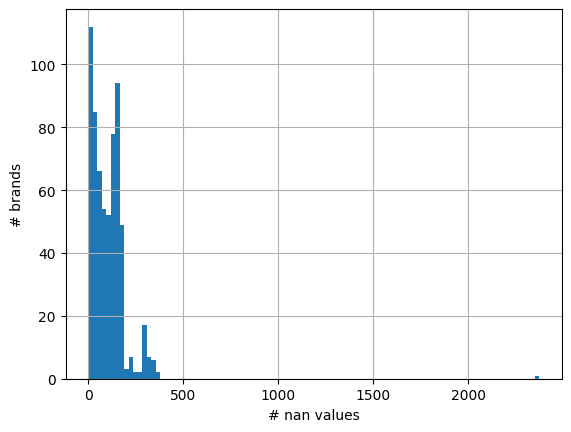

In [21]:
X_uniq[msk_nanrows].business_entity_doing_business_as_name.value_counts().hist(bins=100)
plt.xlabel('# nan values')
plt.ylabel('# brands')

Are there brands that always have nans for some attribute?

In [22]:
na_frac = X_uniq[['business_entity_doing_business_as_name', 'followers', 'pictures',
       'videos', 'comments', 'likes']].groupby('business_entity_doing_business_as_name').apply(lambda x: x.iloc[:,1:].isna().sum()/len(x))

/var/folders/bs/l4gnbytj1sg3frsll1c6ncsw0000gn/T/ipykernel_6298/2826605409.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'videos', 'comments', 'likes']].groupby('business_entity_doing_business_as_name').apply(lambda x: x.iloc[:,1:].isna().sum()/len(x))


In [ ]:
na_frac[na_frac.max(axis=1) > 0.7]

### Country names
Some country names contain semicolons, we want to strip these extra characters

In [ ]:
X.domicile_country_name.unique()

### Correlation matrix
Lets explore the relationship between the variables.

In [ ]:
X_train = X[X['period_end_date'] == '2023-09-16']

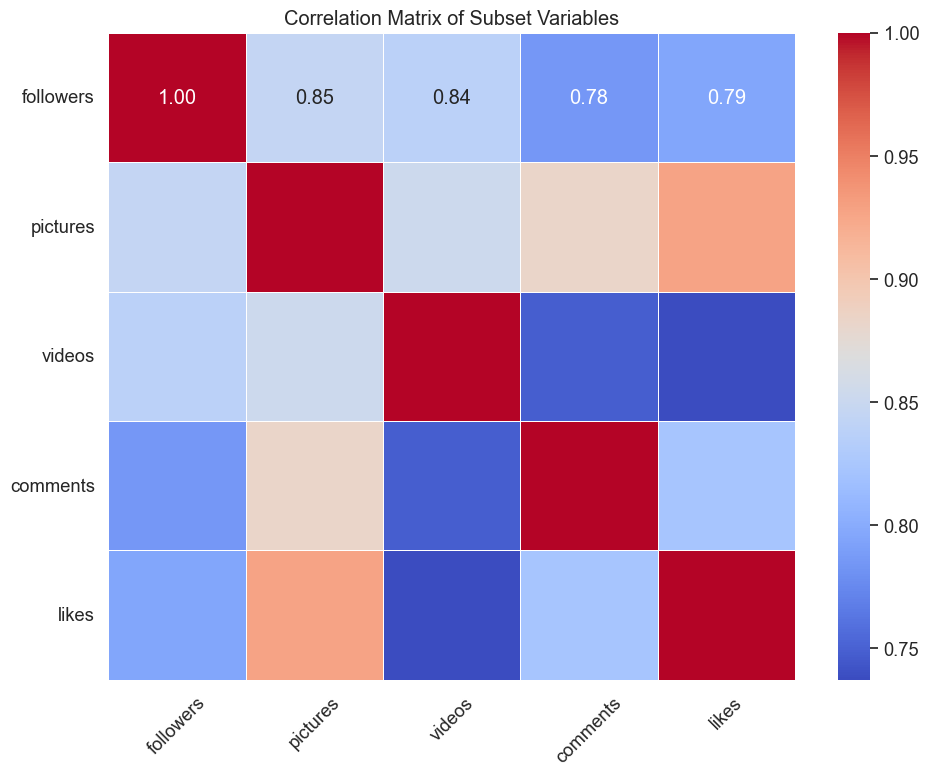

In [57]:
vars = ['followers', 'pictures',
       'videos', 'comments', 'likes'] #column names to correlate

subset_X_train = X[vars]

# Calculate correlation matrix
correlation_matrix = subset_X_train.corr()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=vars,
            yticklabels=vars,
            linewidths=.5)
plt.title('Correlation Matrix of Subset Variables')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In the above figure,  we plot the correlation matrix for the variables `followers`, `pictures`, `videos`, `comment` and  `likes`.


We can observe that the number of followers is the most correlated with number of pictures and videos. This is intuitive, as a brand that posts more can attract more followers.

We also observe that the number of likes is the strongest correlated with the number of pictures.

### Time Series
Lets analyze how brands' metrics evolve during the timeline. 

To this end, we use the preprocessed data, where the preprocessing steps are explained in `preprocessing.ipynb`

In [58]:
PATH_TRAIN = '/Users/yiyily/Desktop/data/train.csv'
PATH_TEST = '/Users/yiyily/Desktop/data/test.csv'

In [59]:
X_train = pd.read_csv(PATH_TRAIN, sep=';')

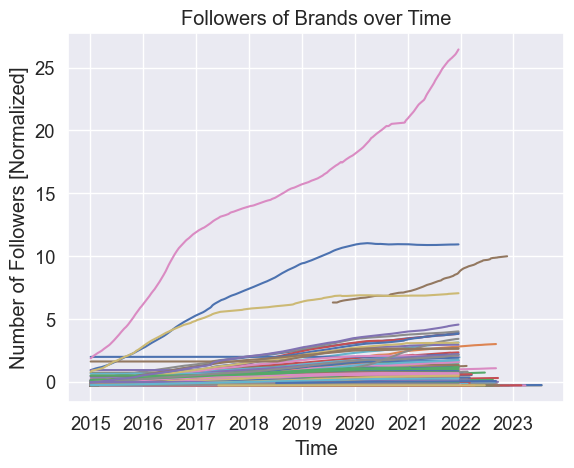

In [62]:
# Convert 'date' column to datetime
X_train['date'] = pd.to_datetime(X_train['date'])

# Group by brand
grouped = X_train.groupby('brand')

# Plot time series for 'followers' for each brand
for brand, group in grouped:
    plt.plot(group['date'], group['followers'], label=brand)


plt.xlabel('Time')
plt.ylabel('Number of Followers [Normalized]')
plt.title('Followers of Brands over Time')
#plt.legend()
plt.show()

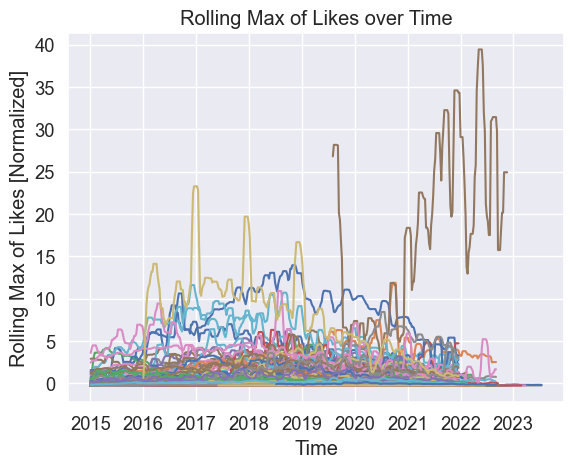

In [64]:
# Convert 'date' column to datetime
X_train['date'] = pd.to_datetime(X_train['date'])

# Group by brand
grouped = X_train.groupby('brand')

# Plot time series for 'followers' for each brand
for brand, group in grouped:
    plt.plot(group['date'], group['likes_rolling_max'], label=brand)


plt.xlabel('Time')
plt.ylabel('Rolling Max of Likes [Normalized]')
plt.title('Rolling Max of Likes over Time')
#plt.legend()
plt.show()

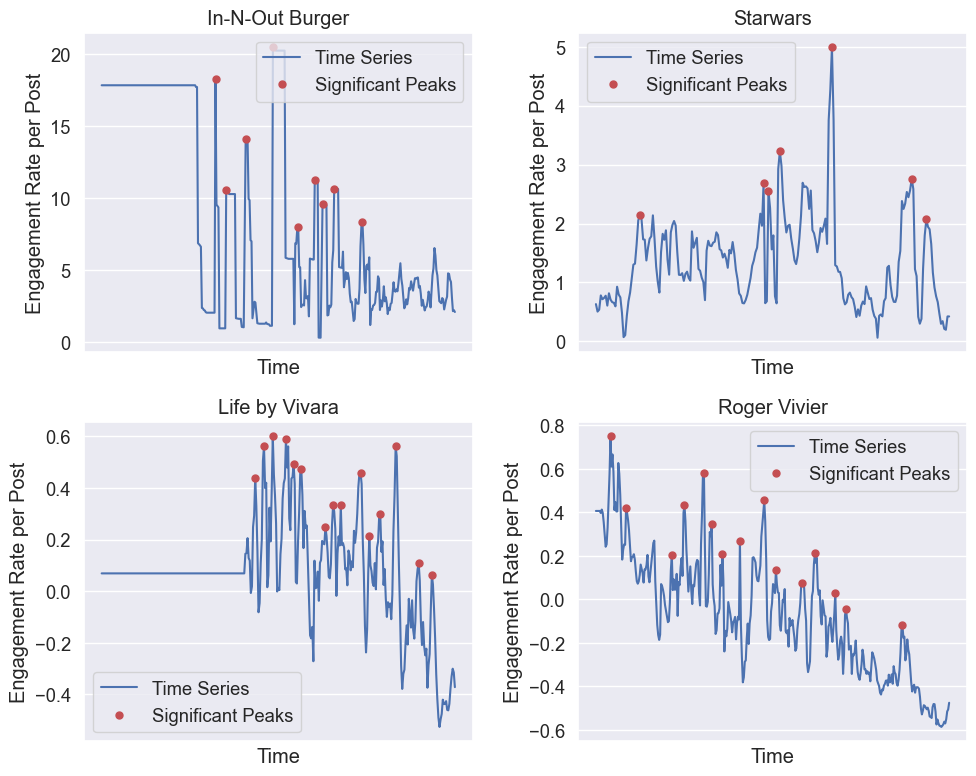

In [77]:
# List of brands to plot
brands = ['In-N-Out Burger', 'Starwars', 'Life by Vivara', 'Roger Vivier']

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i, brand in enumerate(brands):
    # Example time series data (replace this with your actual data)
    time_series = X_train[X_train['brand'] == brand]['engagement_rate_per_post']


    # Find peaks with minimum prominence
    # Set the threshold to be 0.3 times the maximum peak height in the time series
    threshold = 0.3 * time_series.max()
    peaks, _ = find_peaks(time_series, prominence=threshold)

    # Plot the time series
    axs[i].plot(time_series.index, time_series.values, label='Time Series')

    # Plot the significant peaks
    axs[i].plot(time_series.index[peaks], time_series.values[peaks], 'ro', markersize=5, label='Significant Peaks')

    # Add labels and legend
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Engagement Rate per Post')
    axs[i].set_xticks([])
    axs[i].set_title(f'{brand}')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()